In [1]:
import spotpy

# Easy Tutorial

In [2]:
from spotpy import analyser                                     # Load the Plotting extension 
from spotpy.examples.spot_setup_rosenbrock import spot_setup    # Import the two dimensional Rosenbrock example

In [3]:
# Give Monte Carlo algorithm the example setup and saves results in a RosenMC.csv file
sampler = spotpy.algorithms.dds(spot_setup(), dbname='RosenDDS', dbformat='csv')

In [4]:
# sample with the implemented Monte Carlo algorithm
sampler.sample(100000)                # Sample 100,000 parameter combinations
results=sampler.getdata()             # Get the results of the sampler

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  100000  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 100000 repetitions...
Finding best starting point for trial 1 using 500 random samples.
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'RosenDDS.csv' created.
22761 of 100000, maximal objective function=2.42024e+06, time remaining: 00:00:07
44546 of 100000, maximal objective function=2.42024e+06, time remaining: 00:00:05
66308 of 100000, maximal objective function=2.42024e+06, time remaining: 00:00:03
87979 of 100000, maximal objective function=2.42024e+06, time remaining: 00:00:01
Best solution found has obj function value of 2420242.0 at 500



*** Final SPOTPY summary ***
Total Duration: 9.1 seconds
Total Repetitions: 100000
Maximal objective value: 2.42024e+06
Corresponding parameter setting:
x: -10
y: -10
z: -10
******************************



In [ ]:
# what the algorithm has done during the 100.000 iterations
spotpy.analyser.plot_parameterInteraction(results)  

In [ ]:
print(spotpy.analyser.get_best_parameterset(results))

# Link BMI_CFE with Spotpy

In [2]:
import os
#from netCDF4 import Dataset
#from pathlib import Path
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


In [3]:
import sys

import bmi_cfe
import cfe

## set up spotpy class

In [4]:
class spotpy_setup(object): 

    def __init__(self): 
        # initialzie model and calibration parameters
        self.params = [spotpy.parameter.Uniform('bb',0,21.94,optguess=16),
                       spotpy.parameter.Uniform('smcmax',0.20554,1,optguess=0.439), #maybe max = 0.5
                       spotpy.parameter.Uniform('satdk',0,0.000726,optguess=3.38e-6),
                       spotpy.parameter.Uniform('slop',0,1,optguess=0.01),
                       spotpy.parameter.Uniform('max_gw_storage',0.01,0.25,optguess=0.01),
                       spotpy.parameter.Uniform('expon',1,8,optguess=6.0),
                       spotpy.parameter.Uniform('Cgw',1.8e-6,1.8e-3),
                       spotpy.parameter.Uniform('K_lf',0,0.1),
                       spotpy.parameter.Uniform('K_nash',0,0.1),
                       ]
    
        #Load test comparison data (direct runoff) from file ['test_compare.csv']
        data = pd.read_csv('/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500-usgs-hourly.csv')
        self.obs_data = data['QObs(mm/h)'].values
        self.eval_dates = data['date'].values
        #self.eval_dates = [np.datetime64(self.eval_dates[i]) for i in range(len(self.eval_dates))]
        print('###--------- usgs start date: ' + self.eval_dates[0] + '.---------')
        print('###--------- usgs end date: ' + self.eval_dates[-1] + '.---------')

    def parameters(self):
        return spotpy.parameter.generate(self.params)
        
    def simulation(self,vector):
        self.cfemodel = bmi_cfe.BMI_CFE('/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/cal_test_config_cfe.json')
        print('###--------model succesfully setup----------###')
        self.cfemodel.initialize()
        print('###--------model succesfully initialized----------###')

        # Read in Meteorological forcing
        with open(self.cfemodel.forcing_file, 'r') as f:
            self.df_forcing = pd.read_csv(f)

            usgs_start_idx = np.where(self.df_forcing['date']==self.eval_dates[0])
            self.df_forcing = self.df_forcing.iloc[usgs_start_idx[0][0]:,:]

        print(f"###----- forcing_file loaded:{self.cfemodel.forcing_file}. -----###")
        print('###------nldas start date: ' + self.df_forcing['date'].values[0]+ "-----###")
        print('###------nldas end date: ' + self.df_forcing['date'].values[-1]+"-----###")

        print('###-----after defining start date nldas length: ' +  str(len(self.df_forcing['date'].values))+"------###")

        nldas_end_idx = np.where(self.eval_dates==self.df_forcing['date'].values[-1])
        self.eval_dates = self.eval_dates[:nldas_end_idx[0][0]+1]
        self.obs_data = self.obs_data[:nldas_end_idx[0][0]+1]
        print('###---------- after defining usgs end date usgs length: ' +  str(len(self.obs_data)) + '.---------')

        self.generated_param = vector
        print(f"###----------- parameters generated: {self.generated_param}.--------###")
        self.cfemodel.soil_params['bb']=vector[0]
        self.cfemodel.soil_params['smcmax']=vector[1]
        self.cfemodel.soil_params['satdk']=vector[2]
        self.cfemodel.soil_params['slop']=vector[3]
        self.cfemodel.max_gw_storage==vector[4]
        self.cfemodel.expon=vector[5]
        self.cfemodel.Cgw=vector[6]
        self.cfemodel.K_lf=vector[7]
        self.cfemodel.K_nash=vector[8]

        self.outputs=self.cfemodel.get_output_var_names()
        self.output_lists = {output:[] for output in self.outputs}

        # for precip, pet in zip(self.df_forcing['total_precipitation'],self.df_forcing['potential_evaporation']):
        #     #print(f"###----------loaded precip, pet: {precip},{pet}.------------###")
        #     #sys.exit(1)
        #     self.cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
        #     self.cfemodel.set_value('water_potential_evaporation_flux', pet)
        #     self.cfemodel.update()
            
        for precip in self.df_forcing['total_precipitation']:
            self.cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
            self.cfemodel.update()
        
            for output in self.outputs:
                self.output_lists[output].append(self.cfemodel.get_value(output))
           
        self.cfemodel.finalize()

        print(f'###----------output length: {len(self.output_lists["land_surface_water__runoff_volume_flux"])}.---------###')

        return self.output_lists["land_surface_water__runoff_volume_flux"]

    def evaluation(self,evaldates=False):
        if evaldates:
            self.eval_dates_output = [pd.Timestamp(self.eval_dates[i]) for i in enumerate(self.eval_dates)]
            return self.eval_dates_output
        else:
            print(f"length of obs_data: {len(self.obs_data)}.")
            return self.obs_data

    def objectivefunction(self,simulation,evaluation, params=None):
        self.obj_function = spotpy.objectivefunctions.kge(evaluation,simulation)
        return self.obj_function

## Evaluate and Plot

In [5]:
test = spotpy_setup()
sampler = spotpy.algorithms.dds(test,dbname='TestDDS',dbformat='csv')

###--------- usgs start date: 1989-10-01 04:00:00.---------
###--------- usgs end date: 2020-05-28 12:00:00.---------
length of obs_data: 268737.


In [6]:
sampler.sample(10)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  10  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 10 repetitions...
Finding best starting point for trial 1 using 5 random samples.
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=21.378, smcmax=0.291449, satdk=0.000196336, slop=0.907329, max_gw_storage=0.112207, expon=5.57499, Cgw=0.000947403, K_lf=0.0954434, K_nash=0.0276259).--------###


###----------output length: 258153.---------###
1 of 10, maximal objective function=-1e+308, time remaining: 00:00:38
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'TestDDS.csv' created.
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=9.10908, smcmax=0.392391, satdk=0.00047951, slop=0.519248, max_gw_storage=0.228618, expon=2.44124, Cgw=0.000722472, K_lf=0.0267619, K_nash=0.0232648).--------###


###----------output length: 258153.---------###
2 of 10, maximal objective function=-1e+308, time remaining: 00:00:44
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=13.2058, smcmax=0.907532, satdk=0.000246936, slop=0.334622, max_gw_storage=0.224673, expon=7.48809, Cgw=0.000349039, K_lf=0.0631452, K_nash=0.0248853).--------###


###----------output length: 258153.---------###
3 of 10, maximal objective function=-1e+308, time remaining: 00:00:42
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=12.754, smcmax=0.851199, satdk=0.000544891, slop=0.882033, max_gw_storage=0.0490698, expon=6.08737, Cgw=0.00142173, K_lf=0.0120245, K_nash=0.00962871).--------###


###----------output length: 258153.---------###
4 of 10, maximal objective function=-1e+308, time remaining: 00:00:37
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=11.2932, smcmax=0.342314, satdk=9.85849e-05, slop=0.606767, max_gw_storage=0.0898492, expon=4.06841, Cgw=0.000157793, K_lf=0.0735915, K_nash=0.0357826).--------###


###----------output length: 258153.---------###
5 of 10, maximal objective function=-1e+308, time remaining: 00:00:31
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=5.93848, smcmax=0.825252, satdk=0.000165647, slop=0.530329, max_gw_storage=0.0728397, expon=4.27848, Cgw=0.00111004, K_lf=0.0867196, K_nash=0.0812665).--------###


###----------output length: 258153.---------###
6 of 10, maximal objective function=-1e+308, time remaining: 00:00:24
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=4.93859, smcmax=0.905076, satdk=0.000514097, slop=0.870954, max_gw_storage=0.0200894, expon=2.50329, Cgw=0.000807068, K_lf=0.0928002, K_nash=0.0939997).--------###


###----------output length: 258153.---------###
7 of 10, maximal objective function=-1e+308, time remaining: 00:00:16
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=2.38119, smcmax=0.905076, satdk=0.000330807, slop=0.67514, max_gw_storage=0.0200894, expon=3.7794, Cgw=0.000987831, K_lf=0.0366024, K_nash=0.0703287).--------###


###----------output length: 258153.---------###
8 of 10, maximal objective function=-1e+308, time remaining: 00:00:08
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=2.38119, smcmax=0.905076, satdk=0.000514097, slop=0.870954, max_gw_storage=0.0200894, expon=3.7794, Cgw=0.00132802, K_lf=0.0826854, K_nash=0.0939997).--------###


###----------output length: 258153.---------###
9 of 10, maximal objective function=-1e+308, time remaining: 00:00:00
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2019-03-14 12:00:00-----###
###-----after defining start date nldas length: 258153------###
###---------- after defining usgs end date usgs length: 258153.---------
###----------- parameters generated: parameters(bb=2.38119, smcmax=0.905076, satdk=0.000514097, slop=0.870954, max_gw_storage=0.0200894, expon=3.7794, Cgw=0.00129258, K_lf=0.0826854, K_nash=0.0939997).--------###


###----------output length: 258153.---------###
10 of 10, maximal objective function=-1e+308, time remaining: 23:59:52
Best solution found has obj function value of -1e+308 at 5



*** Final SPOTPY summary ***
Total Duration: 93.1 seconds
Total Repetitions: 10
Maximal objective value: -1e+308
Corresponding parameter setting:
bb: nan
smcmax: nan
satdk: nan
slop: nan
max_gw_storage: nan
expon: nan
Cgw: nan
K_lf: nan
K_nash: nan
******************************



[{'sbest': spotpy.parameter.ParameterSet(),
  'trial_initial': [2.3811872138172063,
   0.9050762744808367,
   0.0005140971939754334,
   0.8709535775753602,
   0.020089389591669685,
   3.7793990877741814,
   0.0009878314458604163,
   0.08268536523920605,
   0.09399972392404334],
  'objfunc_val': -1e+308}]

In [7]:
results = sampler.getdata()

The figure as been saved as "Parameter_trace.png


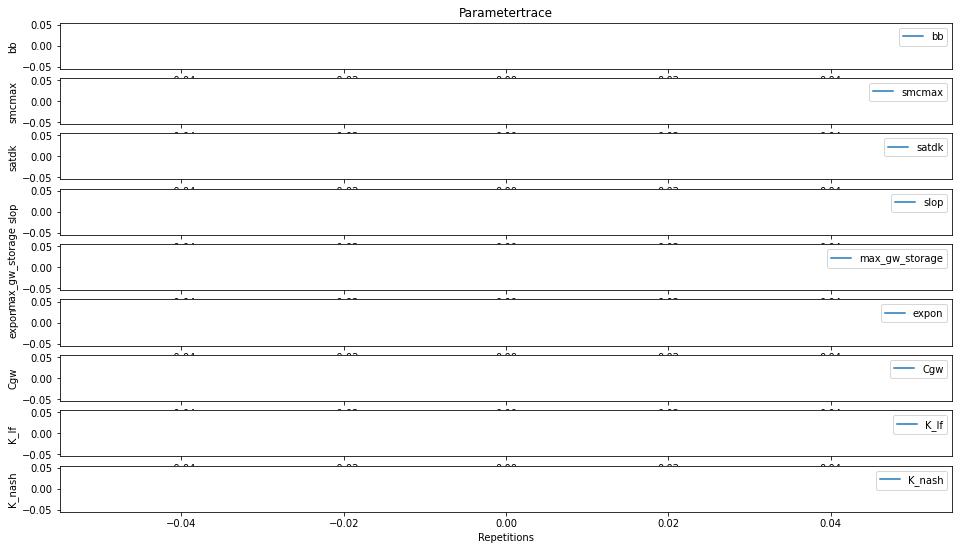

In [75]:
spotpy.analyser.plot_parametertrace(results)

In [15]:
evaluation = test.evaluation()
evaldates= test.evaluation(evaldates=True)

spotpy.analyser.plot_bestmodelruns(results,evaluation,algorithms='dds',dates=evaldates, ylabel='Stream Flow')

length of obs_data: 258153.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices